In [46]:
# Importing the pandas library, which is used for data manipulation and analysis
import pandas as pd

# Importing the numpy library, which is used for numerical operations and handling arrays
import numpy as np

# Importing seaborn for data visualization, particularly statistical plots
import seaborn as sns

# Importing matplotlib for general plotting and graphing, commonly used for creating static visualizations
import matplotlib.pyplot as plt


In [32]:
# Reading the housing data from a CSV file named 'housing_prices.csv'
# The delimiter for separating values is a comma, and the quote character is double quotes
housing_data = pd.read_csv("housing_prices.csv", delimiter=',', quotechar='"')

# Reading the population data from a CSV file named 'population_data.csv'
# The delimiter for separating values is a comma, and the quote character is double quotes
population_data = pd.read_csv("population_data.csv", delimiter=',', quotechar='"')

In [33]:
# Defining the name of the country to filter the population data
country_name = "United Kingdom"

# Filtering the population data to get the row(s) where the "Country Name" matches the defined country_name
country_population = population_data[population_data["Country Name"] == country_name]


In [34]:
# Selecting specific columns from the filtered 'country_population' DataFrame:
# - "Country Name" and "Country Code" columns are kept
# - Adding columns for years 2013 to 2023 dynamically by iterating through the range of years
country_population = country_population.loc[:, ["Country Name", "Country Code"] + [str(year) for year in range(2013, 2024)]]

In [35]:
# Defining the land area of the United Kingdom in square kilometers
land_area_km2 = 243610  # Approx. land area of the UK

# Reshaping the 'country_population' DataFrame using melt:
# - 'Country Name' and 'Country Code' are kept as identifier variables (id_vars)
# - The 'Year' is used as a new column representing each year from 2013 to 2023
# - 'Population' values for each year are now stored in a column called 'Population'
uk_population = country_population.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")

# Converting the 'Year' column from string to integer type for numerical operations
uk_population["Year"] = uk_population["Year"].astype(int)

# Calculating the population density by dividing the population by the land area
# The result is stored in a new column called 'Population Density'
uk_population["Population Density"] = uk_population["Population"] / land_area_km2

In [36]:
# Converting the 'Date' column in the 'housing_data' DataFrame to a datetime format
# This ensures that the 'Date' column is properly recognized as a date type for time-based analysis
housing_data['Date'] = pd.to_datetime(housing_data['Date'])

In [37]:
# Filtering the 'housing_data' DataFrame to select rows where:
# - The month is August (month == 8)
# - The day is the 1st (day == 1)
# - The year is between 2013 and 2023 (inclusive)
filtered_data = housing_data[(housing_data['Date'].dt.month == 8) & (housing_data['Date'].dt.day == 1) & (housing_data['Date'].dt.year >= 2013) & (housing_data['Date'].dt.year <= 2023)]
# Sorting the 'filtered_data' DataFrame by the 'Date' column in ascending order
# This ensures that the data is ordered chronologically
filtered_data = filtered_data.sort_values(by='Date')

In [40]:
# Selecting only the 'Date' and 'Price (All)' columns from 'filtered_data' for the 'housing_data' DataFrame
housing_data = filtered_data[["Date", "Price (All)"]]

# Extracting the year from the 'Date' column and creating a new 'Year' column in the 'housing_data' DataFrame
# The 'Date' column is first converted to datetime format, then the year is extracted
housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year

# Dropping the 'Date' column from the 'housing_data' DataFrame, as the 'Year' column now contains the relevant information
housing_data = housing_data.drop(columns=["Date"])

/var/folders/r9/hs7j8x6s2_qczl2vyt_y375w0000gn/T/ipykernel_5009/2550921810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year


In [49]:
# Merging the 'housing_data' DataFrame with the 'uk_population' DataFrame on the 'Year' column
# The 'how="inner"' ensures that only rows with matching years in both DataFrames are kept
merged_data = pd.merge(housing_data, uk_population, on="Year", how="inner")

# Grouping the merged data by 'Year' and calculating the mean for 'Price (All)' and 'Population Density'
merged_data_grouped = merged_data.groupby("Year")[["Price (All)", "Population Density"]].mean().reset_index()

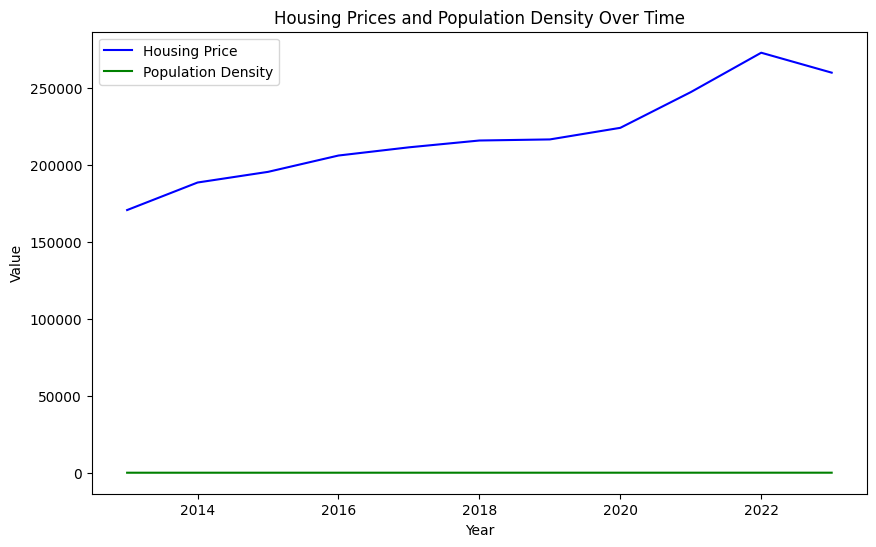

In [50]:
# Creating a line plot to visualize 'Price (All)' and 'Population Density' over 'Year'
plt.figure(figsize=(10, 6))

# Plotting 'Price (All)' over 'Year'
sns.lineplot(data=merged_data_grouped, x='Year', y='Price (All)', label='Housing Price', color='blue')

# Plotting 'Population Density' over 'Year'
sns.lineplot(data=merged_data_grouped, x='Year', y='Population Density', label='Population Density', color='green')

# Adding labels and title
plt.title('Housing Prices and Population Density Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()


In [45]:
# Calculating the Pearson correlation coefficient between 'Price (All)' and 'Population Density'
# The correlation measures the strength and direction of the linear relationship between the two variables
correlation = merged_data["Price (All)"].corr(merged_data["Population Density"])

# Printing the calculated correlation with a formatted output, rounding the value to 2 decimal places
print(f"Correlation between housing prices and population density: {correlation:.2f}")

Correlation between housing prices and population density: 0.94
